In [1]:
import pandas as pd
import finterstellar as fs

In [2]:
path = './data/'
cd = 'S&P 500'

In [3]:
file_name = path + cd + ' Historical Data.csv'
df = pd.read_csv(file_name, index_col='Date')

# 날짜 처리
ld = fs.LoadData()
df = ld.date_formatting(df)    
# date_formatting(데이터프레임) - 날짜 처리

df = ld.price_df_trimming(df, cd)
# price_df_trimming(데이터프레임) - 시세 처리
df.head()

,S&P 500
Date,
2017-01-03,2257.83
2017-01-04,2270.75
2017-01-05,2269.00
2017-01-06,2276.98
2017-01-09,2268.90


In [4]:
trd = fs.SingleAsset()   # fs 라이브러리의 SingleAsset 모듈을 불러와 trd에 로딩

base_date = '2018-01-01'   # 기준일자 설정
base_date = trd.check_base_date(df, base_date)
# check_base_date(데이터프레임, 기준일자) - 기준일자가 데이터프레임에 들어있는지 체크
base_date

Timestamp('2018-01-02 00:00:00')

In [5]:
n = 20     # 평균주가계산 기준일수
sigma = 2     # 편차구간 지정 (시그마의 배수로)

In [6]:
# 볼린저밴드 계산
bb = trd.bollinger_band(df, cd, n, sigma)
# bollinger_band(데이터프레임, 분석대상코드, 평균기준일, 편차구간) - 볼린저밴드 분석값 계산
bb.tail()

,S&P 500,center,ub,lb,band_size
Date,,,,,
2019-04-09,2878.20,2840.6585,2905.201318,2776.115682,129.085635
2019-04-10,2888.21,2844.5230,2910.800744,2778.245256,132.555489
2019-04-11,2888.32,2848.5150,2915.268073,2781.761927,133.506145
2019-04-12,2907.41,2852.7615,2923.242576,2782.280424,140.962152
2019-04-15,2905.58,2856.3935,2929.991395,2782.795605,147.195791


In [7]:
# 샘플링
sample = bb.loc[base_date:]     # 계산 결과를 기준일자 이후만 잘라내 sample 데이터프레임에 저장
sample.head()

,S&P 500,center,ub,lb,band_size
Date,,,,,
2018-01-02,2695.81,2667.0200,2708.811332,2625.228668,83.582665
2018-01-03,2713.06,2670.7010,2715.148434,2626.253566,88.894868
2018-01-04,2723.99,2675.4220,2721.502433,2629.341567,92.160866
2018-01-05,2743.15,2681.1160,2731.157713,2631.074287,100.083427
2018-01-08,2747.71,2686.6525,2740.491519,2632.813481,107.678038


In [8]:
book = trd.create_trade_book(sample, cd)
# create_trade_book(데이터프레임, [종목코드]) - 트레이딩북 생성
book.head()

,S&P 500,t S&P 500,p S&P 500
Date,,,
2018-01-02,2695.81,,
2018-01-03,2713.06,,
2018-01-04,2723.99,,
2018-01-05,2743.15,,
2018-01-08,2747.71,,


In [9]:
# 트레이딩 전략 설정
thd = 'ub'   # 종목 매도 기준 (편차구간상단:ub, 편차구간중심:center)
buy = 'out'    # 종목 매수 기준 (편차구간 진입 시:in, 편차구간 벗어날 시:out)
book = trd.tradings(sample, book, thd, cd, buy, short=False)
# tradings(데이터프레임, 트레이딩북, 매도기준, 종목코드, 매입기준) - 매매전략을 이용한 백테스팅 수행

In [10]:
# 포지션 계산
book = trd.position(book, cd)
# position(트레이딩북, 종목코드) - 트레이딩 전략 수행에 수반되는 포지션 판단
'''
    z : zero
    l : long
    s : short
    zz : zero to zero
    zl : zero to long
    lz : long to zero
'''
book['2018-02-01':'2018-02-20']

,S&P 500,t S&P 500,p S&P 500
Date,,,
2018-02-01,2821.98,,zz
2018-02-02,2762.13,,zz
2018-02-05,2648.94,buy,zl
2018-02-06,2695.14,buy,ll
2018-02-07,2681.66,buy,ll
2018-02-08,2581.00,buy,ll
2018-02-09,2619.55,buy,ll
2018-02-12,2656.00,buy,ll
2018-02-13,2662.94,buy,ll


In [11]:
# 수익률 계산
fund_rtn = trd.returns(book, cd, display=True)
# returns(트레이딩북, 종목코드) - 전략의 수익률 계산

2018-02-05 00:00:00 long S&P 500 2648.94
2018-05-10 00:00:00 long S&P 500 2648.94  | unwind long S&P 500 2723.07  | return: 1.028
2018-06-27 00:00:00 long S&P 500 2699.63
2018-08-27 00:00:00 long S&P 500 2699.63  | unwind long S&P 500 2896.74  | return: 1.073
2018-10-10 00:00:00 long S&P 500 2785.68
2019-03-18 00:00:00 long S&P 500 2785.68  | unwind long S&P 500 2832.94  | return: 1.017
Accumulated return: 12.18 %  ( # of trade: 3  , # of win: 3  )
Avg return: 0.039 , Prob. of win: 1.0


In [12]:
# 벤치마크 수익률
bm_rtn = trd.benchmark_return(book, cd)
# benchmark_return(트레이딩북, 종목코드) - 벤치마크 수익률 계산

BM return: 7.78 %
{'S&P 500': 1.0778}


In [13]:
# 초과 수익률
exs_rtn = trd.excess_return(fund_rtn, bm_rtn)
# excess_return(전략수익률, 벤치마크수익률) - 초과수익률 계산

Excess return: 4.08 %


그래프로 표현하기

In [14]:
v = fs.Visualize()    # fs 라이브러리의 Visualize() 모듈을 불러와 v로 지정

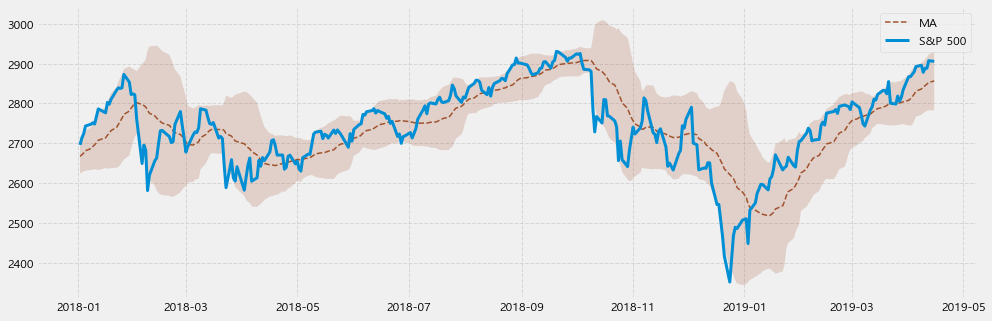

In [15]:
v.bb_trend_view(sample, cd, (15,5))
# v 모듈의 bb_trend_view(데이터프레임, 편차구간, 종목코드, (사이즈)) 함수 - 볼린저밴드 그래프 그리기

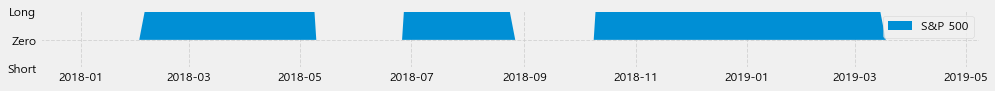

In [16]:
v.position_view(book, cd)
# v 모듈의 position_view(트레이딩북, 종목코드, (사이즈)) 함수 - 보유내역 그래프 그리기

최근 전략

In [17]:
last_date = sample.index[-1].date().strftime('%Y-%m-%d')
# 현재 투자전략 추출을 위해 데이터 상 최종일 추출
last_date

'2019-04-15'

In [18]:
trd.trading_strategy(sample, thd, cd, last_date)
# trading_strategy(데이터프레임, 매도기준, 종목코드, 최종일) - 트레이딩 전략 판단

As of 2019-04-15 this model suggests you to just wait


'just wait'

In [19]:
trd.position_strategy(book, cd, last_date)
# position_strategy(트레이딩북, 종목코드 최종일) - 포지션 구축 전략 판단

As of 2019-04-15 your model portfolio ['S&P 500'] needs to be composed of nothing


'nothing'

백테스팅 결과인 트레이딩북을 한번 구경해볼까요?

In [20]:
book['2018-02-01':]

,S&P 500,t S&P 500,p S&P 500,return,acc return,psS&P 500
Date,,,,,,
2018-02-01,2821.98,,zz,1.000000,1.000000,0
2018-02-02,2762.13,,zz,1.000000,1.000000,0
2018-02-05,2648.94,buy,zl,1.000000,1.000000,1
2018-02-06,2695.14,buy,ll,1.000000,1.000000,1
2018-02-07,2681.66,buy,ll,1.000000,1.000000,1
2018-02-08,2581.00,buy,ll,1.000000,1.000000,1
2018-02-09,2619.55,buy,ll,1.000000,1.000000,1
2018-02-12,2656.00,buy,ll,1.000000,1.000000,1
2018-02-13,2662.94,buy,ll,1.000000,1.000000,1
